# Machine Learning in 5G Challenge.

## Initialize


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance


import random
from random import seed
from random import randint

import torch
from torch.nn import Linear, ReLU, PReLU, Sequential, BatchNorm1d

from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Data/...'             ## Path to where data is stored
results_path = '/content/drive/My Drive/Results/...'       ## Path where results will be stored
input_train = data_path+'Train/input_node_files/'
output_train_sim = data_path+'Train/output_simulator/'
input_test = data_path+'Test/input_node_files_test/'
output_test_sim = data_path+'Test/output_simulator_test/'

# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loader

### Read Simulator

In [4]:
def read_output_simulator(fp, N_AP):       
    line = fp.readline()                    # Initial line (name of the scenaio)        
    throughput = fp.readline()              # Throughput  
    airTime = fp.readline()                 # AirTime
   
    RSSI = fp.readline()                    # RSSI
    interference = np.zeros((N_AP,N_AP))    # Interferences
    for i in range(N_AP):         
        inter = fp.readline()  
        if(i==0):
            interference[0] = np.array(inter[1:len(inter)-2].split(',')).astype(np.float)
        else:        
            interference[i] = np.array(inter[:len(inter)-2].split(',')).astype(np.float) 
    SINR = fp.readline()
    SINR = np.array(SINR[1:len(SINR)-2].split(',')).astype(np.float)
    list_of_SINR = np.split(SINR, np.where(SINR == np.inf)[0][1:])
    RSSI = np.array(RSSI[1:len(RSSI)-2].split(',')).astype(np.float)
    list_of_RSSI = np.split(RSSI, np.where(RSSI == np.inf)[0][1:])
    airTime = np.array(airTime[1:len(airTime)-3].split(';'))
    list_of_airTime = list()
    for i in range(N_AP):
        list_of_airTime.append(np.array(airTime[i].split(',')).astype(np.float))
    
    throughput = np.array(throughput[1:len(throughput)-2].split(',')).astype(np.float)     
    list_of_throughput = np.split(throughput, np.where(RSSI == np.inf)[0][1:])      

    return( interference, list_of_RSSI, list_of_SINR, list_of_airTime, list_of_throughput )

### Read data

In [5]:
def load_info(input_nodes_sceXX_path, simulator_file_path, size, N_APs):
    features = np.zeros((size,N_APs,15))
    target = np.zeros((size,N_APs,1))    

    ##############################################################
    ####################### Features #############################
    ##############################################################
    ## 0: SINR mean                                             ##
    ## 1: SINR std                                              ##
    ## 2: RSSI mean                                             ##
    ## 3: RSSI std                                              ##
    ## 4: Dist mean                                             ##
    ## 5: Dist std                                              ##
    ## 6: num of STAs                                           ##
    ## 7-14: Airtime x Channel                                  ##

    fp = open(simulator_file_path, 'r')
    for f in range(size):
        ##### READ OUTPUT FILE ##### 
        interferences, RSSI, SINR, list_of_airTime, throughput = read_output_simulator(fp, N_APs)     # Interference [N_APs,N_APs],  list_RSSI(i)[0-20], list_Throughput(i)[0-20]
       
        ##### READ INPUT FILE ######
        csvData = pd.read_csv(input_nodes_sceXX_path + format(f,'03')+'.csv', sep = ';', usecols=['node_type', 'min_channel_allowed', 'max_channel_allowed'])
        channels_data = csvData.values
        APs_channels_data = channels_data[np.where(channels_data[:,0]==0)][:,1:3]

        csvData = pd.read_csv(input_nodes_sceXX_path + format(f,'03')+'.csv', sep = ';', usecols=['node_type', 'x(m)', 'y(m)'])
        positions = csvData.values
        list_of_positions = np.split(positions, np.where(positions[:,0]==0)[0])[1:]


        #### Compute available channels ####
        APs_airTime = np.zeros((N_APs, 8))
        APs_openChan = np.zeros((N_APs, 8))
        for ap in range(N_APs):
            APs_airTime[ap,APs_channels_data[ap,0]:APs_channels_data[ap,1]+1] = list_of_airTime[ap]/100
            APs_openChan[ap,APs_channels_data[ap,0]:APs_channels_data[ap,1]+1] = 1
            
        for i, thr in enumerate(throughput):   
            n=len(thr[1:])
            distances = list_of_positions[i]
            dist = np.zeros((len(distances)-1))
            for sta in range(1,len(distances)):
                dist[sta-1] = distance.euclidean(distances[0][1:],distances[sta][1:])
            

            SINR[i][np.isnan(SINR[i])] = -9
            features[f,i,0] = np.mean(SINR[i][1:])
            features[f,i,1] = np.std(SINR[i][1:])
            features[f,i,2] = np.mean(RSSI[i][1:])
            features[f,i,3] = np.std(RSSI[i][1:])
            features[f,i,4] = np.mean(dist)           
            features[f,i,5] = np.std(dist)
            features[f,i,6] = n
            features[f,i,7:] = APs_airTime[i]

            target[f,i,0] = thr[0]

    return(features, target)

### Dataset Loader

In [6]:
####################################
# 1- Dataset class
####################################
  
class Data(torch.utils.data.Dataset):
    
    # Initialization method for the dataset
    def __init__(self, input_path, simulator_path, type = 'train', scen = 1):
        
        APs_info = list()
        APs_throughput = list()

        if type == 'train':
            print("Loading Training Dataset ...", scen)

            if scen == 1:
                print("Loading Scen 1 (A) ...")
                APs_infoA, APs_throughputA = load_info(input_train+'sce1a/input_nodes_sce1a_deployment_', output_train_sim+'script_output_sce1a.txt', 100, 12)
                print("Loading Scen 1 (B) ...")
                APs_infoB, APs_throughputB = load_info(input_train+'sce1b/input_nodes_sce1b_deployment_', output_train_sim+'script_output_sce1b.txt', 100, 12)
                print("Loading Scen 1 (C) ...")
                APs_infoC, APs_throughputC = load_info(input_train+'sce1c/input_nodes_sce1c_deployment_', output_train_sim+'script_output_sce1c.txt', 75, 12)

                for i in range(100):
                    APs_info.append(APs_infoA[i])
                    APs_throughput.append(APs_throughputA[i])
                for i in range(100):
                    APs_info.append(APs_infoB[i])
                    APs_throughput.append(APs_throughputB[i])
                for i in range(75):
                    APs_info.append(APs_infoC[i])
                    APs_throughput.append(APs_throughputC[i])
            elif scen == 2:
                print("Loading Scen 2 (A) ...")
                APs_infoA,  APs_throughputA = load_info(input_train+'sce2a/input_nodes_sce2a_deployment_', output_train_sim+'script_output_sce2a.txt', 100, 8)
                print("Loading Scen 2 (B) ...")
                APs_infoB,  APs_throughputB = load_info(input_train+'sce2b/input_nodes_sce2b_deployment_', output_train_sim+'script_output_sce2b.txt', 100, 8)
                print("Loading Scen 2 (C) ...")
                APs_infoC,  APs_throughputC = load_info(input_train+'sce2c/input_nodes_sce2c_deployment_', output_train_sim+'script_output_sce2c.txt', 75, 8)

                for i in range(100):
                    APs_info.append(APs_infoA[i])
                    APs_throughput.append(APs_throughputA[i])
                for i in range(100):
                    APs_info.append(APs_infoB[i])
                    APs_throughput.append(APs_throughputB[i])
                for i in range(75):
                    APs_info.append(APs_infoC[i])
                    APs_throughput.append(APs_throughputC[i])
                        
        elif type == 'test':
            print("Loading Test Dataset Scen {} ...".format(scen))
            if scen == 1:
                APs_4_info, APs_4_throughput = load_info(input_test+'test_1/input_nodes_test_sce1_deployment_', output_test_sim+'script_output_test_sce1.txt', 50, 4)
                for i in range(50):
                    APs_info.append(APs_4_info[i])
                    APs_throughput.append(APs_4_throughput[i])
            elif scen == 2:
                APs_6_info, APs_6_throughput  = load_info(input_test+'test_2/input_nodes_test_sce2_deployment_', output_test_sim+'script_output_test_sce2.txt', 50, 6)
                for i in range(50):
                    APs_info.append(APs_6_info[i])
                    APs_throughput.append(APs_6_throughput[i])
            elif scen == 3:
                APs_8_info, APs_8_throughput  = load_info(input_test+'test_3/input_nodes_test_sce3_deployment_', output_test_sim+'script_output_test_sce3.txt', 50, 8)
                for i in range(50):
                    APs_info.append(APs_8_info[i])
                    APs_throughput.append(APs_8_throughput[i])
            elif scen == 4:                
                APs_10_info, APs_10_throughput  = load_info(input_test+'test_4/input_nodes_test_sce4_deployment_', output_test_sim+'script_output_test_sce4.txt', 50, 10)
                for i in range(50):
                    APs_info.append(APs_10_info[i])
                    APs_throughput.append(APs_10_throughput[i])
        print("DONE !")
        self.data_info = APs_info
        self.target = APs_throughput
            
    def __getitem__(self, index):        
        data_info = self.data_info[index]
        target = self.target[index]
        
        info = torch.tensor(np.array(data_info, dtype=np.float32))
        target = torch.tensor(np.array(target, dtype=np.float32))

        # return the features and the target as a tuple
        return (info, target)
        
    # Return the number of scenarios
    def __len__(self):
        return len(self.target)
 

### Load data

In [ ]:
dataset_train_1 = Data(input_train, output_train_sim, type = 'train', scen=1)
dataset_train_2 = Data(input_train, output_train_sim, type = 'train', scen=2)
dataset_test_4 = Data(input_test, output_test_sim, type = 'test', scen=1)
dataset_test_6 = Data(input_test, output_test_sim, type = 'test', scen=2)
dataset_test_8 = Data(input_test, output_test_sim, type = 'test', scen=3)
dataset_test_10 = Data(input_test, output_test_sim, type = 'test', scen=4)

# Split the dataset (90%, 10%)
train1, validation1 = torch.utils.data.random_split(dataset_train_1, [250,25])
train2, validation2 = torch.utils.data.random_split(dataset_train_2, [250,25])

train_loader = torch.utils.data.DataLoader(dataset= torch.utils.data.ConcatDataset((train1, train2)), batch_size=50)
validation_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.ConcatDataset((validation1, validation2)), batch_size=25)
# train_loader = torch.utils.data.DataLoader(dataset= torch.utils.data.ConcatDataset((dataset_train_1, dataset_train_2)), batch_size=55)


test_loader_4 = torch.utils.data.DataLoader(dataset=dataset_test_4, batch_size=50)
test_loader_6 = torch.utils.data.DataLoader(dataset=dataset_test_6, batch_size=50)
test_loader_8 = torch.utils.data.DataLoader(dataset=dataset_test_8, batch_size=50)
test_loader_10 = torch.utils.data.DataLoader(dataset=dataset_test_10, batch_size=50)

# THROUGHPUT PREDICTIVE MODEL

### MLP for throughput prediction

In [8]:
#################################
# 3- Implement an MLP using PyTorch
#################################
class MLP_PyTorch(nn.Module):
    def __init__(self):   
        super(MLP_PyTorch, self).__init__()     
        
        self.Linear_sinr = nn.Linear(2, 1)  
        self.Linear_rssi = nn.Linear(2, 1)
        self.Linear_dist = nn.Linear(2, 1)
        self.Linear_signal = nn.Sequential(
            nn.Linear(4, 3),
            nn.PReLU(),
        )
        self.Linear_airtime = nn.Sequential(
            nn.Linear(8, 3),
            nn.PReLU(),
        )
        self.Linear_throughput = nn.Sequential(
            nn.Linear(6,7),
            nn.PReLU(),
            nn.Linear(7,1),
            nn.ReLU(),
        )
        self.norm3 = BatchNorm1d(4)
        self.prelu = PReLU()
        

    # Define the forward pass of the module using the sub-modules declared in the initializer
    def forward(self, X):
        batch_size = X.size(0)
        N_APs = X.size(1)
        n = X[:,:,6,np.newaxis]

        sinr = self.Linear_sinr(X[:,:,:2])
        rssi = self.Linear_rssi(X[:,:,2:4])
        dist = self.Linear_dist(X[:,:,4:6])

        signal = torch.cat((rssi, dist, sinr, n), axis=2)
        signal = self.norm3(torch.flatten(signal,end_dim=1)).reshape(batch_size,N_APs,4)
        signal = self.prelu(signal)
        signal = self.Linear_signal(signal)        

        airtime = self.Linear_airtime(X[:,:,7:])

        throughput = self.Linear_throughput(torch.cat((signal,airtime),axis=2))

        return throughput


### Trainer

In [9]:
# Function to train our MLP with PyTorch
def train_PyTorch(NN, train_loader, validation_loader, criterion,  optimizer = None, num_epochs = 5000, model_name='MLP.ckpt', device='cpu'):
    train_list_loss = []
    validation_list_loss = [] 
    for epoch in range(num_epochs):        
        loss_avg = 0
        nBatches = 0        
        validation_loss_avg = 0
        validation_nBatches = 0
        
        NN.train()
        for i, (data, targets) in enumerate(train_loader):
            X = data.to(device)
            y = targets.to(device)
            
            # reset optimizer at each epoch
            optimizer.zero_grad()
           
            # make prediction
            yHat = NN.forward(X)

            # compute the loss function
            loss = criterion(yHat,y)
        
            # Backward and optimize
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1

        NN.eval()
        for i, (data, targets) in enumerate(validation_loader):
            X = data.to(device)
            y = targets.to(device)
            
            # make prediction
            yHat = NN.forward(X)

            # compute the loss function
            loss = criterion(yHat,y)

            validation_loss_avg += loss.cpu().item()
            validation_nBatches+=1


        # Print loss and save the value at each iteration
        if epoch%100 == 0 : 
            print('Loss {} = {} , {}'.format(epoch,loss_avg / nBatches, validation_loss_avg / validation_nBatches))
        train_list_loss.append(loss_avg / nBatches)
        validation_list_loss.append(validation_loss_avg / validation_nBatches)



    print('Loss {} = {} , {}'.format(epoch,loss_avg / nBatches, validation_loss_avg / validation_nBatches))
    torch.save(NN.state_dict(), results_path + model_name)
    return train_list_loss, validation_list_loss

### Execution

Loss 0 = 10464.348291015625 , 10857.03369140625
Loss 100 = 384.407405090332 , 435.1339569091797
Loss 200 = 271.8519714355469 , 307.1531066894531
Loss 300 = 196.04926376342775 , 207.07758331298828
Loss 400 = 183.88642044067382 , 191.13725662231445
Loss 500 = 177.19973373413086 , 180.8058204650879
Loss 600 = 174.21511001586913 , 177.93603134155273
Loss 699 = 169.70102920532227 , 171.79266357421875


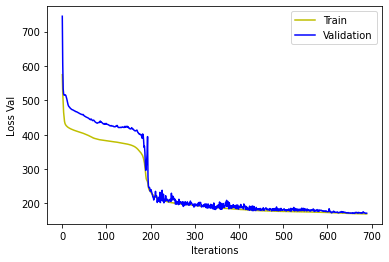

In [13]:
# Initialize a Pytorch MLP
NN = MLP_PyTorch().to(device)

optimizer = torch.optim.Adam(NN.parameters(), lr= 2E-2) 
criterion = nn.MSELoss()

#Train MLP using Pytorch:
train_list_loss, validation_list_loss = train_PyTorch(NN, train_loader, validation_loader, criterion, num_epochs = 700, optimizer = optimizer, device=device)

# Plot the evolution of the loss function during training
plt.plot(train_list_loss[10:],c='y', label="Train")
plt.plot(validation_list_loss[10:],c='b', label="Validation")
plt.xlabel('Iterations')
plt.ylabel('Loss Val')
plt.legend(loc="upper right")
plt.show()

## If the loss gets suck, repeat the execution, this may happend when weights are initialized randomly

torch.Size([5000]) torch.Size([5000])


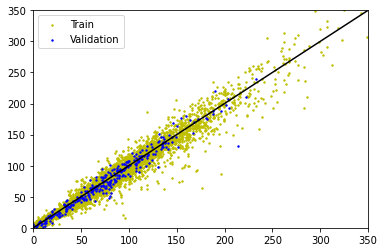

In [15]:
NN = MLP_PyTorch()
NN.eval()
NN.load_state_dict(torch.load(results_path + 'MLP.ckpt'))

y_train = torch.empty(0)
y_hat_train = torch.empty(0)
for x, y in train_loader:
  y_hat_train = torch.cat((y_hat_train,torch.flatten(NN(x))))
  y_train = torch.cat((y_train,torch.flatten(y)))
print(y_hat_train.shape, y_train.shape)
plt.scatter(y_hat_train.detach(), y_train, s=2,c='y', label= "Train")

x_test, y_test = next(iter(validation_loader))
y_test = torch.flatten(y_test)
y_hat_test = torch.flatten(NN(x_test))
plt.scatter(y_hat_test.cpu().detach(), y_test, s=2,c='b', label="Validation")

plt.plot(np.arange(350),c='black')
plt.ylim(0, 350)
plt.xlim(0, 350)
plt.legend(loc="upper left")
plt.show()

# TEST

## LOAD & EXECUTE

In [18]:
## Load, compute predictions.

NN = MLP_PyTorch()
NN.eval()
NN.load_state_dict(torch.load(results_path + 'MLP.ckpt'))
data_4, target_4 = next(iter(test_loader_4))
data_6, target_6 = next(iter(test_loader_6))
data_8, target_8 = next(iter(test_loader_8))
data_10, target_10 = next(iter(test_loader_10))

APs_4_predicted_throughput = NN.forward(data_4)
APs_6_predicted_throughput = NN.forward(data_6)
APs_8_predicted_throughput = NN.forward(data_8)
APs_10_predicted_throughput = NN.forward(data_10)

def print_plot_scenario(predictions, targets, num_of_scen, N_APs):
    results = np.zeros((num_of_scen))
    for i in range(num_of_scen):
        results[i] = criterion(predictions[i], targets[i]).item()
    print('\n %d APs :\n'%(N_APs), np.sort(results))

    y_test = torch.flatten(targets)
    y_hat_test = torch.flatten(predictions).detach().numpy()
    print(y_test.shape)
    plt.scatter(y_hat_test, y_test, s=2)
    plt.ylabel('Real Throughput')
    plt.xlabel('Predicted Throughput')
    plt.plot(np.arange(350),c='black')
    plt.ylim(0, 350)
    plt.xlim(0, 350)
    plt.show()


4 TOTAL Mean squared error: 463.93
6 TOTAL Mean squared error: 373.48
8 TOTAL Mean squared error: 256.37
10 TOTAL Mean squared error: 283.99

 4 APs :
 [   7.59025955   25.13788223   33.14500809   39.61937714   40.07956314
   46.47572327   48.13679504   49.27365875   55.89484787   69.75027466
   77.68452454   81.61389923   88.21012115   90.33211517  103.17651367
  122.02392578  122.40706635  124.09805298  147.59997559  156.54904175
  186.65435791  187.94433594  190.93295288  199.95361328  219.14892578
  225.17071533  226.55122375  263.64294434  264.63452148  303.52160645
  319.77072144  321.45617676  328.08694458  343.6027832   356.76260376
  388.98977661  407.11602783  460.55706787  485.7175293   500.23068237
  548.01446533  583.6998291   606.09594727  807.9543457   833.7411499
  948.32623291 1076.37719727 1211.58935547 4357.78417969 4513.875     ]
torch.Size([200])


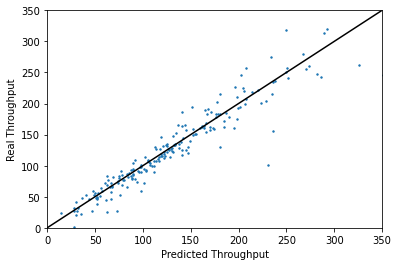


 6 APs :
 [   7.47628641   19.89400864   21.89832878   25.55013466   45.44393539
   45.80825806   47.50090027   53.42047119   56.15447998   65.1202774
   72.05381012   73.85199738   74.25429535   82.82624054  106.27731323
  112.05715179  113.23748779  135.2535553   153.00482178  154.02920532
  180.63146973  188.5007782   188.68658447  190.53770447  196.99633789
  226.33992004  238.40820312  250.58679199  283.59625244  338.85861206
  347.41699219  351.37149048  357.42929077  406.27890015  418.13162231
  476.6020813   510.43933105  581.71734619  671.31158447  678.75897217
  697.41033936  800.60888672  805.51092529  809.70678711  823.27490234
  868.55596924  941.1963501  1146.96105957 1433.11083984 1799.96240234]
torch.Size([300])


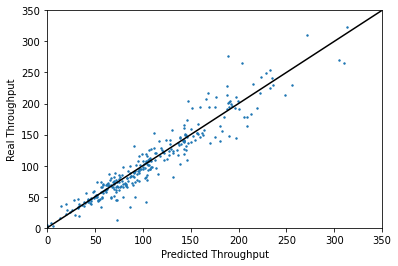


 8 APs :
 [  24.49695778   28.32730103   31.93435478   37.83514404   47.95172501
   56.94458389   62.01351547   68.82800293   70.42356873   74.56481934
   75.63075256   76.14411926   86.00966644   90.05726624   90.72563934
   99.051651    103.36152649  106.11374664  106.95737457  107.00063324
  107.02670288  107.3256073   120.35173035  124.38100433  144.87684631
  159.51170349  162.49581909  176.29486084  179.4019928   181.7374115
  184.62867737  190.91223145  234.99931335  237.57180786  261.4619751
  268.26635742  328.69766235  338.07394409  338.90979004  388.55160522
  477.759552    515.94921875  516.00616455  521.54327393  658.39935303
  702.02514648  714.00250244  790.79553223  893.95965576 1348.03942871]
torch.Size([400])


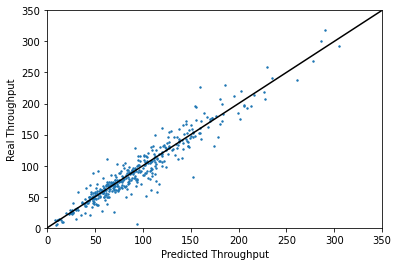


 10 APs :
 [  29.227314     31.19542885   39.19820786   39.80447006   42.51771545
   42.52977753   54.94311523   56.41886139   60.62106323   61.32082367
   73.26564026   75.46952057   96.98323059   99.52091217  127.26383209
  138.92147827  149.98414612  151.59951782  156.97154236  158.66226196
  163.55397034  164.32070923  164.64505005  170.72770691  181.22932434
  190.22738647  211.84475708  225.33200073  241.00131226  255.63908386
  262.67709351  272.27822876  272.76904297  273.19390869  294.2572937
  310.83587646  325.1194458   371.7305603   374.84469604  377.79763794
  401.55383301  421.28598022  478.51800537  620.42150879  658.90808105
  802.11358643  825.83251953 1010.09051514 1090.36035156 1099.93054199]
torch.Size([500])


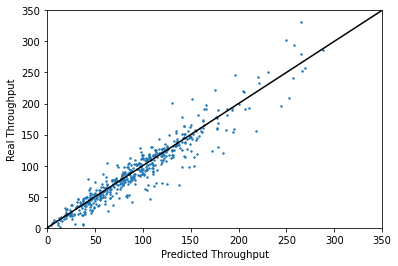

In [19]:
## Compute the MSE of each scenario and plot the predictions.

criterion = nn.MSELoss() 

print("4 TOTAL Mean squared error: %.2f" % criterion(APs_4_predicted_throughput,target_4).item())
print("6 TOTAL Mean squared error: %.2f" % criterion(APs_6_predicted_throughput, target_6).item())
print("8 TOTAL Mean squared error: %.2f" % criterion(APs_8_predicted_throughput, target_8).item())
print("10 TOTAL Mean squared error: %.2f" % criterion(APs_10_predicted_throughput, target_10).item())

print_plot_scenario(APs_4_predicted_throughput, target_4, 50, 4)
print_plot_scenario(APs_6_predicted_throughput, target_6, 50, 6)
print_plot_scenario(APs_8_predicted_throughput, target_8, 50, 8)
print_plot_scenario(APs_10_predicted_throughput, target_10, 50, 10)


## Test Graphical Representation

For each Scenario, Compute the MSE and plot a random deployment

### SCEN 1

In [ ]:
print("TOTAL Mean squared error: %.2f" % criterion(target_4, APs_4_predicted_throughput))
print()
item = 0
item = randint(0, 49)

print(item,"Mean squared error: %.2f" % criterion(target_4[item], APs_4_predicted_throughput[item]))

print(APs_4_predicted_throughput[item])
print(target_4[item])

# GRAPHICAL REPRESENTATION:
plt.plot(APs_4_predicted_throughput[item].detach(), linestyle='--', marker='o', color='b')
plt.plot(target_4[item].detach(), linestyle='--', marker='o', color='y')
plt.ylim(0, 500)
plt.show()



### SCEN 2

In [ ]:
print("TOTAL Mean squared error: %.2f" % criterion(target_6, APs_6_predicted_throughput))
print()

item = 33
# item = randint(0, 49)

print(item,"Mean squared error: %.2f" % criterion(target_6[item], APs_6_predicted_throughput[item]))

print(APs_6_predicted_throughput[item])
print(target_6[item])

# GRAPHICAL REPRESENTATION:
plt.plot(APs_6_predicted_throughput[item].detach(), linestyle='--', marker='o', color='b')
plt.plot(target_6[item].detach(), linestyle='--', marker='o', color='y')
plt.ylim(0, 500)
plt.show()

### SCEN 3

In [ ]:
print("TOTAL Mean squared error: %.2f" % criterion(target_8, APs_8_predicted_throughput))
print()

item = 0
item = randint(0, 49)

print(item,"Mean squared error: %.2f" % criterion(target_8[item], APs_8_predicted_throughput[item]))

print(APs_8_predicted_throughput[item])
print(target_8[item])

# GRAPHICAL REPRESENTATION:
plt.plot(APs_8_predicted_throughput[item].detach(), linestyle='--', marker='o', color='b')
plt.plot(target_8[item].detach(), linestyle='--', marker='o', color='y')
plt.ylim(0, 500)
plt.show()

### SCEN 4

TOTAL Mean squared error: 283.99

28 Mean squared error: 401.55
tensor([[ 97.2339],
        [101.8341],
        [ 49.0464],
        [109.0457],
        [141.1654],
        [ 28.0038],
        [150.3591],
        [ 67.5469],
        [ 63.1715],
        [193.6048]], grad_fn=<SelectBackward>)
tensor([[ 83.2900],
        [ 90.6800],
        [ 33.1500],
        [129.7600],
        [178.0600],
        [ 22.2000],
        [166.1000],
        [ 77.4900],
        [ 27.4900],
        [193.1500]])


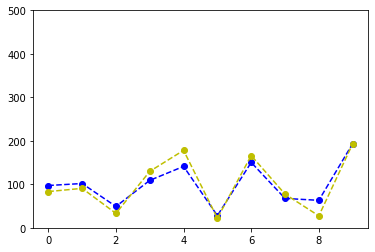

In [22]:
print("TOTAL Mean squared error: %.2f" % criterion(target_10, APs_10_predicted_throughput))
print()

item = 0
item = randint(0, 49)

print(item,"Mean squared error: %.2f" % criterion(target_10[item], APs_10_predicted_throughput[item]))

print(APs_10_predicted_throughput[item])
print(target_10[item])

# GRAPHICAL REPRESENTATION:
plt.plot(APs_10_predicted_throughput[item].detach(), linestyle='--', marker='o', color='b')
plt.plot(target_10[item].detach(), linestyle='--', marker='o', color='y')
plt.ylim(0, 500)
plt.show()

## SAVE RESULTS

In [ ]:
print('Saving...')
print('1')
for i in range(50):
    np.savetxt(results_path+'test scenario 1 - 4 APs/throughput_'+format(i+1,'1')+'.csv', [APs_4_predicted_throughput[i].detach().numpy().reshape(4)], delimiter=',',fmt='%.2f')
print('2')
for i in range(50):
    np.savetxt(results_path+'test scenario 2 - 6 APs/throughput_'+format(i+1,'1')+'.csv', [APs_6_predicted_throughput[i].detach().numpy().reshape(6)], delimiter=',',fmt='%.2f')
print('3')
for i in range(50):
    np.savetxt(results_path+'test scenario 3 - 8 APs/throughput_'+format(i+1,'1')+'.csv', [APs_8_predicted_throughput[i].detach().numpy().reshape(8)], delimiter=',',fmt='%.2f')
print('4')
for i in range(50):
    np.savetxt(results_path+'test scenario 4 - 10 APs/throughput_'+format(i+1,'1')+'.csv', [APs_10_predicted_throughput[i].detach().numpy().reshape(10)], delimiter=',',fmt='%.2f')
print('DONE!')